# Medical Masks Dataset Crop faces and classify
This kernel consists two parts:
1. Crop faces from photos using XML metadata and put them in folders to prepared for `flow_from_directory`;
2. Classify faces in two categories 'good' and 'bad'.

In [114]:
import tensorflow as tf
import numpy as np
import os
import glob
import math
import matplotlib.pyplot as plt
import random
from xml.etree import ElementTree
from PIL import Image, ImageOps, ImageDraw

import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import sys

from tensorflow.keras.utils import Progbar
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [115]:
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

2.1.0
Found GPU at: /device:GPU:0


In [116]:

random_seed = 10

img_height = 64
img_width = 64
img_channels = 3
verbose = 1

np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Prepare data

In [117]:
import os
images_dir = '/kaggle/input/medical-masks-dataset/images'
meta_dir = '/kaggle/input/medical-masks-dataset/labels'
data_dir = './source'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
model_dir='./source/maskn9.h5'

In [118]:
!rm -rf {data_dir}
!mkdir {data_dir}

### Generate random image path

In [119]:
import glob
def random_image(images_dir):
    files = glob.glob(os.path.join(images_dir, '*'), recursive=True)
    return random.choice(files)

image_path = random_image(images_dir)
image_path

'/kaggle/input/medical-masks-dataset/images/maxresdefault.jpg'

### Load, crop and resize image

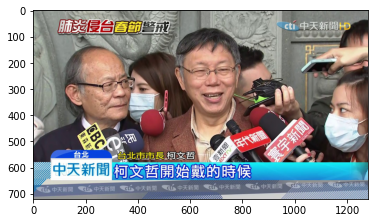

In [120]:
def load_image(image_path):
    return Image.open(image_path).convert("RGB")

image = load_image(image_path)
plt.imshow(image)

### Get metadata XML filename for an image

In [121]:
def image_meta_path(image_path, meta_dir):
    image_filename = os.path.basename(image_path)
    basename = os.path.splitext(image_filename)[0]
    return os.path.join(meta_dir, f"{basename}.xml")

image_meta_path(image_path, meta_dir)

'/kaggle/input/medical-masks-dataset/labels/maxresdefault.xml'

### Parse image metadata from XML file

In [122]:
def get_regions_meta(image_path):
    meta_file = image_meta_path(image_path, meta_dir)
    root = ElementTree.parse(meta_file).getroot()
    regions = []
    for object_tag in root.findall('object'):
        name = object_tag.find('name').text
        xmin = int(object_tag.find('bndbox/xmin').text)
        xmax = int(object_tag.find('bndbox/xmax').text)
        ymin = int(object_tag.find('bndbox/ymin').text)
        ymax = int(object_tag.find('bndbox/ymax').text)
        regions.append({ "name": name, "coordinates": (xmin, ymin, xmax, ymax) })
    return regions

regions_meta = get_regions_meta(image_path)
regions_meta

[{'name': 'bad', 'coordinates': (174, 230, 366, 435)},
 {'name': 'good', 'coordinates': (356, 269, 496, 435)},
 {'name': 'bad', 'coordinates': (577, 179, 777, 401)},
 {'name': 'good', 'coordinates': (1108, 341, 1273, 533)}]

### Crop faces from image

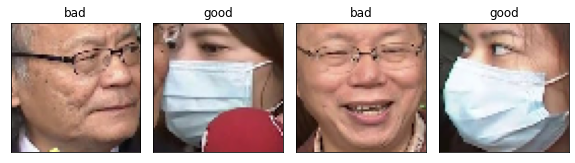

In [123]:
def process_image(image, size=None, crop=None):
    if not crop is None:
        image = image.crop(crop)
    if not size is None:
        image = image.resize(size)
    return image

def crop_regions(image, regions_meta, size=None):
    return list(map(lambda region_meta: (region_meta['name'], process_image(image, crop=region_meta['coordinates'], size=size)), regions_meta))

regions = crop_regions(image, regions_meta, size=(img_width, img_height))

def plot_regions(regions):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    columns = 4
    rows = math.ceil(len(regions) / columns)
    
    for i, region in enumerate(regions):
        label, image = region
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(label)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(image)
        
    plt.show()

plot_regions(regions)

### Determine directory for a particular image
Directory is determined according to image label and random train/test split ratio. Only 'good' and 'bad' images processed, other images are droppped.

In [124]:
test_split = 0.2

def image_dir(label):
  if not label in ['good', 'bad']:
    return None

  if random.random() > test_split:
    split_dir = train_dir
  else:
    split_dir = test_dir
  
  return os.path.join(split_dir, label)

image_dir('good')

'./source/test/good'

### Crop faces from image and save them in proper directory 

In [125]:
def prepare_image(image_path, image_index, size=None):
    regions_meta = get_regions_meta(image_path)
    image = load_image(image_path)
    regions = crop_regions(image, regions_meta, size=size)
    for region_index, region in enumerate(regions):
        label, image = region
        region_dir = image_dir(label)
        if region_dir == None:
            continue
        if not os.path.isdir(region_dir):
            os.makedirs(region_dir)
        region_filename = f"{image_index}_{region_index}.jpg"
        image.save(os.path.join(region_dir, region_filename), "JPEG")

### Process all images

In [126]:
def prepare_images(images_dir, size=None):
    images_paths = glob.glob(os.path.join(images_dir, '*'), recursive=True)
    progbar = Progbar(target = len(images_paths))
    progbar.update(0)
    for image_index, image_path in enumerate(images_paths):
        prepare_image(image_path, image_index, size=size)
        progbar.update(image_index + 1)

prepare_images(images_dir, size=(img_width, img_height))

678/678 [==============================] - 16s 23ms/step


### Show directory tree

In [127]:
!ls -R | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/'

   .
   |-source
   |---test
   |-----bad
   |-----good
   |---train
   |-----bad
   |-----good


# Model


### Prepare train and validation image data generators

In [128]:
batch_size = 16

train_data = ImageDataGenerator(
  rescale=1./255,
  rotation_range=15,
  width_shift_range=0.3,
  height_shift_range=0.3,
  brightness_range=(0.67, 1.0),
  shear_range=0.3,
  zoom_range=0.3,
  horizontal_flip=True,
  fill_mode='nearest'
).flow_from_directory(
  batch_size=batch_size,
  directory=train_dir,
  shuffle=True,
  target_size=(img_height, img_width), 
  class_mode="binary"
)

validation_data = ImageDataGenerator(
  rescale=1./255
).flow_from_directory(
  batch_size=batch_size,
  directory=test_dir,
  shuffle=True,
  target_size=(img_height, img_width), 
  class_mode="binary"
)

Found 3036 images belonging to 2 classes.
Found 752 images belonging to 2 classes.


### Simple CNN model

In [129]:
model = Sequential([
    Conv2D(64, (2, 2), activation='relu', padding='same', input_shape=(img_height, img_width, img_channels)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])

### Train model

In [130]:
import keras
epochs =10
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=["accuracy"]
)
history = model.fit(
  train_data,
  epochs=epochs,
  steps_per_epoch=len(train_data),
  validation_data=validation_data,
  validation_steps=len(validation_data)
)


Train for 190 steps, validate for 47 steps
Epoch 1/10
190/190 [==============================] - 7s 39ms/step - loss: 0.2892 - accuracy: 0.8831 - val_loss: 0.1258 - val_accuracy: 0.9535
Epoch 2/10
190/190 [==============================] - 7s 35ms/step - loss: 0.1981 - accuracy: 0.9193 - val_loss: 0.1243 - val_accuracy: 0.9495
Epoch 3/10
190/190 [==============================] - 7s 35ms/step - loss: 0.1782 - accuracy: 0.9325 - val_loss: 0.1392 - val_accuracy: 0.9441
Epoch 4/10
190/190 [==============================] - 7s 37ms/step - loss: 0.1663 - accuracy: 0.9368 - val_loss: 0.1437 - val_accuracy: 0.9415
Epoch 5/10
190/190 [==============================] - 7s 38ms/step - loss: 0.1584 - accuracy: 0.9361 - val_loss: 0.1642 - val_accuracy: 0.9362
Epoch 6/10
190/190 [==============================] - 7s 36ms/step - loss: 0.1633 - accuracy: 0.9325 - val_loss: 0.1005 - val_accuracy: 0.9601
Epoch 7/10
190/190 [==============================] - 7s 35ms/step - loss: 0.1514 - accuracy: 0.938

In [131]:
model.save(model_dir)

# PREDICTIONS

In [132]:
from keras.preprocessing import image
imgs='./source/test/good/100_5.jpg'
imgs1='./source/test/bad/108_0.jpg'
r = '/kaggle/input/masksasd/nomask.jpg'
r2='/kaggle/input/masksasd/mask1.jpeg'


img = image.load_img(r, target_size=(64, 64))
x = image.img_to_array(img)/255
x = np.expand_dims(x,axis=0)


print(model.predict(x))


[[0.8492168]]
[[[[0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   ...
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]]

  [[0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   ...
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]]

  [[0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   ...
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]]

  ...

  [[0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   ...
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]]

  [[0.98039216 0.98039216 0.980

# Analyze

In [133]:
best_accuracy = np.max(history.history['val_accuracy'])
best_loss = np.min(history.history['val_loss'])
print(f'Best accuracy: {best_accuracy}')
print(f'Best logloss: {best_loss}')

Best accuracy: 0.9667553305625916
Best logloss: 0.09121799041477448


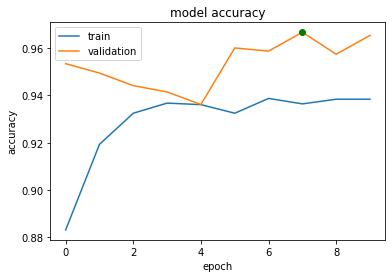

In [134]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(np.argmax(history.history['val_accuracy']), best_accuracy, 'o', color='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()